<a href="https://colab.research.google.com/github/AilingLiu/Survival_analysis/blob/master/KaplanMeierFitter_and_Log_Rank_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)

In [2]:
data_link = 'https://raw.githubusercontent.com/AilingLiu/Survival_analysis/master/Data/simulated%20HF%20mort%20data%20for%20GMPH%20(1K)%20final.csv'

hf = pd.read_csv(data_link, index_col='id')
hf.head()

,death,los,age,gender,cancer,cabg,crt,defib,dementia,diabetes,hypertension,ihd,mental_health,arrhythmias,copd,obesity,pvd,renal_disease,valvular_disease,metastatic_cancer,pacemaker,pneumonia,prior_appts_attended,prior_dnas,pci,stroke,senile,quintile,ethnicgroup,fu_time
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,2,90,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,4,0,0,0,0,2.0,NaN,416
2,0,10,74,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,9,1,0,0,0,4.0,1.0,648
3,0,3,83,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3.0,1.0,466
4,0,1,79,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,9,2,1,1,0,5.0,1.0,441
5,0,17,94,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2.0,1.0,371


 Note:
 <br> gender=1 is male and gender=2 is female

In [0]:
#uncomment below if lifelines has not been intalled
# !pip install lifelines

Survival probability for male

In [0]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

male_mask = hf.gender==1
T = hf[male_mask]['fu_time']
C = hf[male_mask]['death']

kmf.fit(T, event_observed=C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 548 total observations, 280 right-censored observations>

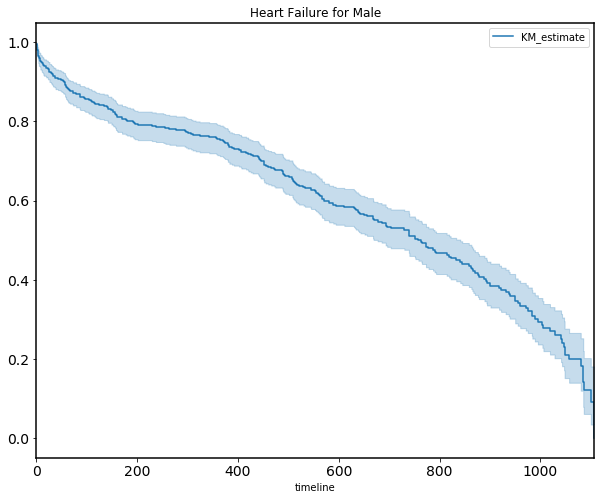

In [0]:
kmf.plot(title='Heart Failure for Male', figsize=(10, 8))

survival probability for both male and female

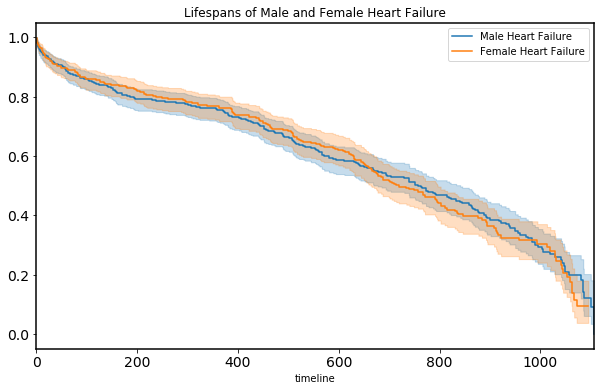

In [0]:
female_mask = hf.gender==2
T2 = hf[female_mask]['fu_time']
C2 = hf[female_mask]['death']

kmf.fit(T, event_observed=C, label='Male Heart Failure')
ax = kmf.plot(figsize=(10, 6))

kmf.fit(T2, event_observed=C2, label='Female Heart Failure')
kmf.plot(ax=ax)

plt.title('Lifespans of Male and Female Heart Failure')
plt.legend(loc='upper right')
plt.show()

Log rank test

Null Hypothesis:

The survival rates over time between Male and Female are the same.

From the plot above, it looks these two groups are quite similar in survival rate. The log-rank test compares the survival time by gender. It’s the most popular method of comparing the survival of patient groups that takes the whole follow-up period into account. Its big advantage is that we don’t need to know anything about the shape of the survival curve or the distribution of survival times. It’s based on a comparison of the observed numbers of deaths and the numbers of deaths expected if in fact there were no difference in the probability of death between the groups (genders in this case) and uses a chi-squared test.

In [0]:
from lifelines.statistics import logrank_test
lgtest = logrank_test(T, T2, C, C2, alpha=99)

In [0]:
lgtest.print_summary()



The resulting p-value at 0.77 is high. There’s therefore no good evidence of a difference between the genders in their survival times.

Log rank test on survival rate over time between 65+ age group and under 65 group

In [15]:
age65plus_mask = hf['age'] >= 65
T1, C1 = hf[age65plus_mask]['fu_time'], hf[age65plus_mask]['death']
T2, C2 = hf[~age65plus_mask]['fu_time'], hf[~age65plus_mask]['death']

from lifelines.statistics import logrank_test

lgtest = logrank_test(T1, T2, C1, C2, alpha=99)
lgtest.print_summary()

The resulting p-value less than 0.005, which is less than significant level at 0.01. There is a significant difference between the age group in their survival times. Let's make a plot to see the differences visually.

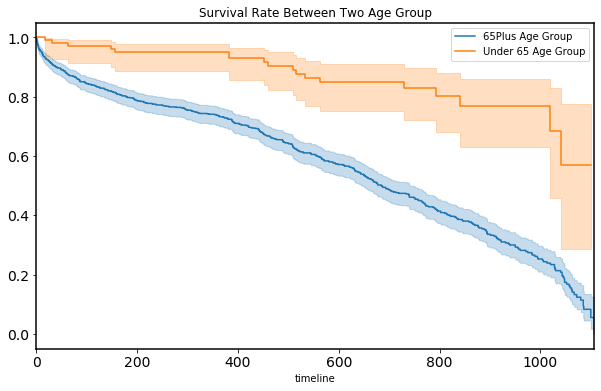

In [16]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T1, event_observed=C1, label='65Plus Age Group')
ax = kmf.plot(figsize=(10, 6))
kmf.fit(T2, event_observed=C2, label='Under 65 Age Group')
kmf.plot(ax=ax)

plt.title('Survival Rate Between Two Age Group')
plt.legend(loc='upper right')
plt.show()

From the above survival curve, patients under 65 has a higher survival rate the same time t, compared to those over 65 years old. We can also use scipy.stats.chi2_contingency test to verfiy how far is the observed data from the expected data.

In [17]:
hf['above65'] = age65plus_mask*1
freq_tab = pd.crosstab(hf['death'], hf['above65'])
freq_tab

above65,0,1
death,,
0,97,411
1,18,474


In [18]:
from scipy.stats import chi2_contingency

c_stat, pval, df, expected_val = chi2_contingency(freq_tab)
expected_val = expected_val.round(1)

print('Expected Value if these two categorical varianbles are not related:')
display(expected_val)

print('Calculated P value: {}'.format(pval))

Expected Value if these two categorical varianbles are not related:


array([[ 58.4, 449.6],
       [ 56.6, 435.4]])

Calculated P value: 4.3438615086999114e-14


The 115 younger patients (those with above65 = 0) had 18 observed deaths, but we would expect 56.6 under the null hypothesis of no difference in survival times by age group. In contrast, the older group had more deaths than expected under the null, which confirms our conclusion that younger patients live significantly longer after hospital admission than older ones do.